# Seminar: Exploratory Data Analysis in Python/Pandas environment

* We will use the Ames Housing dataset of real estate sales
* The content is based on the Kaggle Competition House Prices Advanced Regression Techniques. See details [here](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

### Goals for today:
* Read files (csv)
* Display needed parts of df
* Aggregate df
* Filter df

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

## Task 1: Read data and undestand it's structure

### 1a. Load training dataset (in `./data/train.csv`) and display 5 random rows

Hint: Use `.style` attribute to display all columns

Hint: See  `./data/data_description.txt` for documentation of variables

In [3]:
df = pd.read_csv("train.csv")

### 1b. What is the distribution `SalePrice` variable?

* plot histogram (`.hist()` on `pd.Series`) with bin width $10,000

Hint: Specify bins using range

### 1c. Split columns between quantitative and qualitative variables
Store column names in separate lists of strings `quantitative` and `qualitative`

Hint: `.dtypes` attribute contains a series with strings describing dtype of the data

### 1c* displace df with only quantitative columns

### 1d. Are `dtype`s correct? 

* visually check whether all the columns look correctly parsed

### 1e. Plot number of missing data for all columns

### For the better visiability drop columns with no missing data

## Task 2: Aggregation

### 2.1 Calculate the average LotArea for each year (YrSold)

### 2.2 Calculate the average SalePrice for each street (Street)

### 2.2 Calculate the average SalePrice for Grvl street (Street)

### 2.3 Calculate the average SalePrice for Grvl street (Street) But! Take into account only flats which cost more than 300000

## Task 3 Filtering

### 3.1 How many flats cost less than 200000 and have a 'Normal' condition (column SaleCondition)

### 3.2 How many flats cost less than 200000 or have a 'Normal' condition (column SaleCondition)

### 3.3 How many flats cost have more areas on the second floor(2ndFlrSF) then on the first one(1stFlrSF)?

### What is the average cost (in thousands) for such type of the flats?

# BONUSES

## Task 1: Study relationships between variables

### 1a. see correlation matrix

NameError: name 'quantitative' is not defined

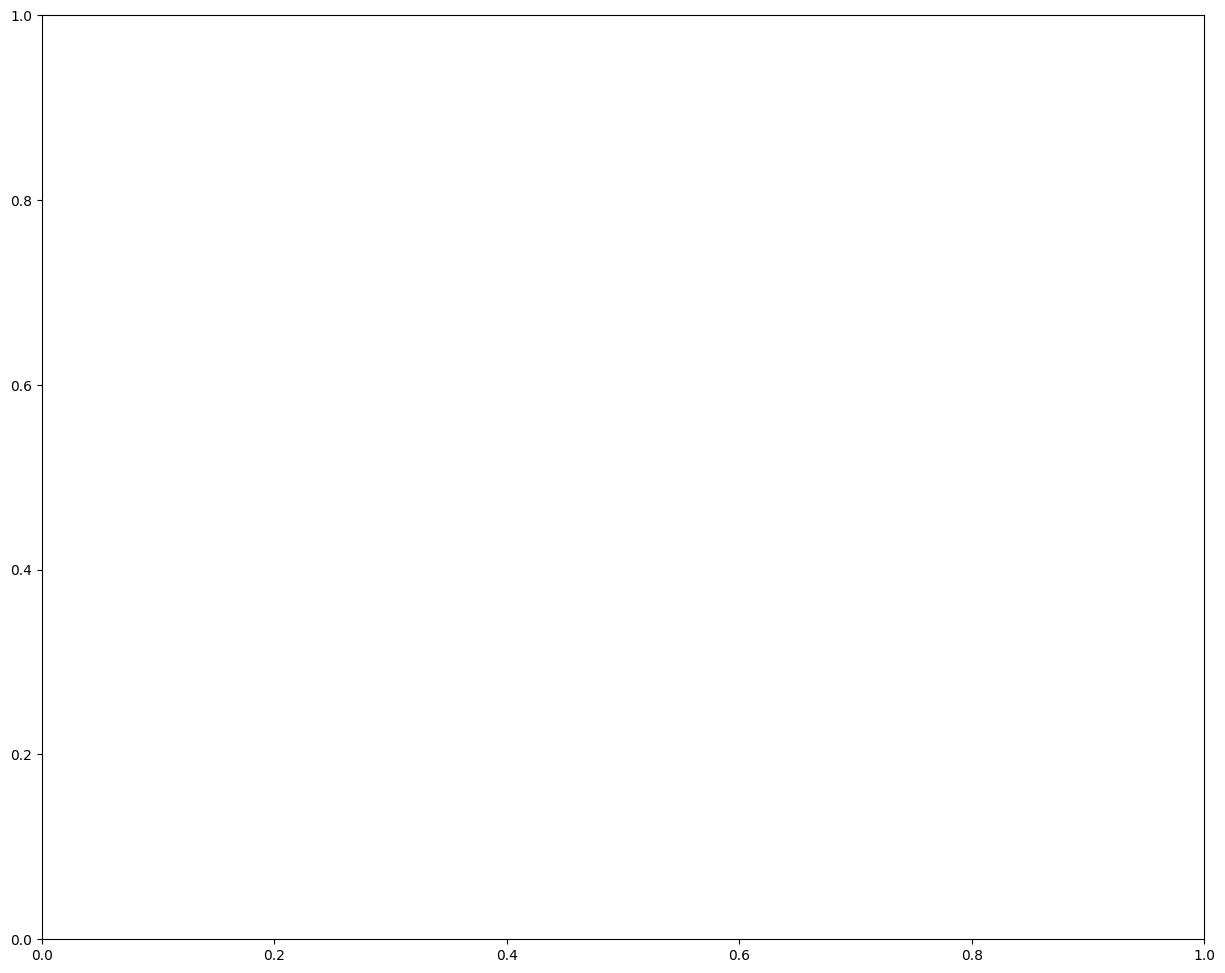

In [4]:
fig=plt.subplots(1,1,figsize=(15,12))
sns.heatmap(df[quantitative].corr(),vmin=-1,cmap='coolwarm',annot=True,fmt='0.1f')

### 2b. Boxplots for categorical variables

In [ ]:
sns.boxplot(data=df,x='MSZoning',y='SalePrice')

## Task 2: ANOVA disparity estimations 

### One-way ANOVA 
* Question: Do sale prices differ across categories of certain feature?
* Test: Do price means across factors with a feature differ in their underlying distribution? 
* Are prices of houses with pool drawn from distribution with different mean than prices of house without a pool? 

* We will test this on all features and plot results

### 2a. Function for estimating ANOVA for one feature
* Your task is to complete a following snippet:


```python

 def anova_feature(qualitative_series, quantitative_series):
    '''
    Performs One-way ANOVA testing whether all levels of `qualitative` series are drawn from distributions with equal means

    Expects:
    - 'qualitative_series': Series with categorical data delienating indivudal groups
    - 'quantitative_series': Series with value data on which the distribution is tested
    
    Uses `scipy.stats.f_oneway` to deliver the test.

    Returns pd.Series with `statistic`, `p_value` and `disparity` measure. `statistic` and `p_value` are calculated by `scipy.stats.f_oneway`. Disparity is calculated as 1/log(p_value).
    '''
    samples =  {
        factor: quantitative_series.loc[qualitative_series.fillna('MISSING') == factor] for factor in qualitative_series.fillna('MISSING').unique()
    }

    anova_result =  stats.f_oneway(*samples.values())
    
    pass
```

In [ ]:
def anova_feature(qualitative_series, quantitative_series):
    '''
    Performs One-way ANOVA testing whether `quantitative_series` across levels of `qualitative_series` are drawn from distributions with equal means

    Expects:
    - 'qualitative_series': Series with categorical data delienating indivudal groups
    - 'quantitative_series': Series with value data on which the distribution is tested
    

    Returns Series with test statistic, p-value
    '''
    samples =  {
        factor: quantitative_series.loc[qualitative_series.fillna('MISSING') == factor]for factor in qualitative_series.fillna('MISSING').unique()
    }

    statistic, pvalue =  stats.f_oneway(*samples.values())
    
    return pd.Series({
        'statistic':statistic,
        'p_value':pvalue,
        'disparity': math.log(1./pvalue)
    })

anova_feature(df.MasVnrType, df.SalePrice)

### 2b. Generate dataframe with ANOVA test of all quantitative columns on `SalePrice` in the dataset

In [ ]:
anova = pd.DataFrame({
    col: anova_feature(df[col],df.SalePrice) for col in qualitative
}).T
anova

### 2c. Plot the disparity measure

In [ ]:
anova.disparity.sort_values(ascending=False).plot.bar(figsize=(12,3))

## Task 3: Encode qualitative variables as quantitative
### 3a. Feature-level function

* Write a function that  an input dataframe with encoded version
* Complete the following snippet

In [ ]:
def encode_qualitative_feature(quantitative_series, qualitative_series, sorting_function=np.mean,suffix='_E'):
    '''
    Ranks `qualitative_series` according to sorting function applied on `quantitative_series` and return its rank as a series. 
    
    Series name is extended with `suffix`.
    '''
    encode_df = pd.DataFrame({
        quantitative_series.name:quantitative_series,
        qualitative_series.name:qualitative_series 
    })

    sorting = encode_df.groupby(qualitative_series.name)[quantitative_series.name].apply(np.mean).rank()

    return qualitative_series.map(sorting).rename(f'{qualitative_series.name}{suffix}')

In [ ]:
encode_qualitative_feature(df.SalePrice, df.KitchenQual)

## 3b. Apply on all qualitative features


In [ ]:
def encode_columns(df, columns, sorting_function=np.mean,suffix='_E'):
    for col in columns:
        ranked_col = encode_qualitative_feature(df.SalePrice, df[col])
        df[ranked_col.name] = ranked_col

    return df

df_encoded =encode_columns(df.copy(), qualitative, sorting_function=np.mean,suffix='_E')
df_encoded